## BIAS VARIANCE EXAMPLE

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.utils import resample
from tqdm import tqdm

## Synthetic data 

In [3]:

X, y = make_moons(n_samples=500, noise=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=7, stratify=y
)

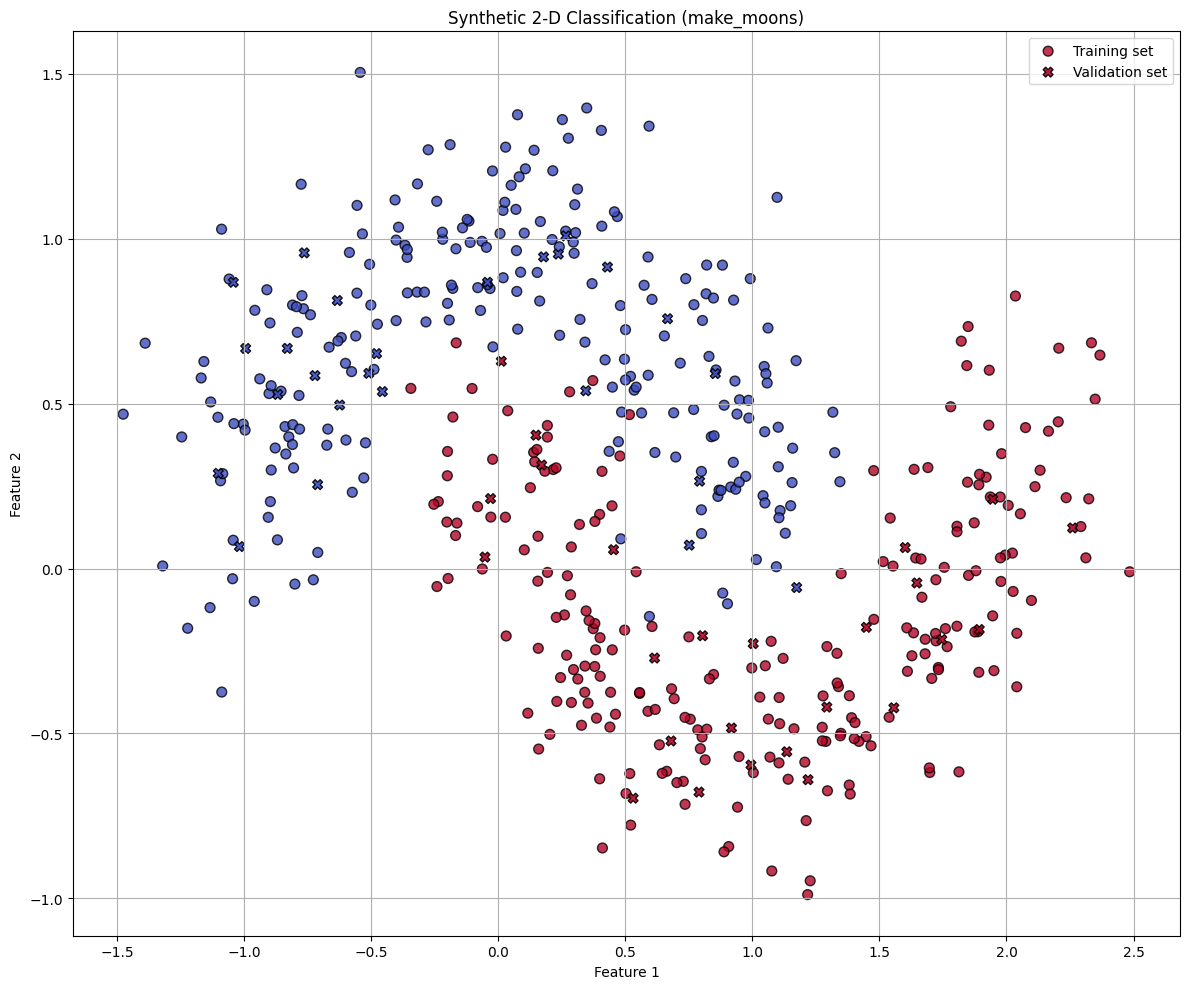

In [4]:
plt.figure(figsize=(12, 10))

# Training set (blue circles)
plt.scatter(
    X_train[:, 0], X_train[:, 1],
    c=y_train, cmap="coolwarm",
    s=50, alpha=0.8, edgecolor='k',
    label='Training set'
)

# Validation set (green crosses)
plt.scatter(
    X_val[:, 0], X_val[:, 1],
    c=y_val, cmap="coolwarm",
    marker='X', s=50, alpha=0.9, edgecolor='k',
    label='Validation set'
)

plt.title("Synthetic 2‑D Classification (make_moons)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Helper function: train a logistic regression with polynomial features

### Polynomial Features with scikit‑learn

`PolynomialFeatures` is a convenient tool for creating a new feature matrix that contains all polynomial combinations of the original features up to a specified degree.  
It is commonly used to give a linear model (e.g., linear regression, logistic regression, SVM, etc.) the ability to capture non‑linear relationships without having to hand‑craft the new features yourself.

## Definition

+ Given an input matrix $X$ of shape $(n_{samples}, n_{features})$, it returns a new matrix $X_{poly}$ of shape $(n_{samples}, n_{output})$ where: $X_{poly}[:, i] = \prod_{j=1}^k x_j ^{a_j} $ for all multi‑indices $(a_0, a_1, …, a_{i-1})$ such that $0 ≤ a_j ≤ degree$ and $\sum_{j=0}^i a_j = degree$ and with $i > $ the original feature indices.  
+ If interaction_only=True, the constraint $a_j \in {0,1}$ is added, so only cross‑terms (no squares or higher powers of a single feature) are generated.

In [5]:
def train_poly_lr(degree, C=1.0):
    """
    Train LogisticRegression on polynomial features of given degree.
    """
    poly = PolynomialFeatures(degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    clf = LogisticRegression(
        penalty='l2',
        C=C,                
        solver='lbfgs',
        max_iter=2000,
        random_state=0,
    )
    clf.fit(X_train_poly, y_train)

    # Store transformer to reuse for predictions, the flexibility of objects in python
    clf.poly = poly
    return clf

### Iterate over the different degrees

In [6]:
max_degree = 25
degrees = list(range(1, max_degree + 1))

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for d in degrees:
    clf = train_poly_lr(d, C=1.0)

    X_train_poly = clf.poly.transform(X_train)
    X_val_poly   = clf.poly.transform(X_val)

    # Probabilities for log‑loss (cross‑entropy)
    train_proba = clf.predict_proba(X_train_poly)
    val_proba   = clf.predict_proba(X_val_poly)

    # Training & validation log‑loss
    train_losses.append(log_loss(y_train, train_proba))
    val_losses.append(log_loss(y_val, val_proba))

    # Accuracy
    train_accuracies.append(accuracy_score(y_train, clf.predict(X_train_poly)))
    val_accuracies.append(accuracy_score(y_val, clf.predict(X_val_poly)))    

#  Bootstrap bias/variance estimation 

## Bootstrap bias/variance estimation is a resampling technique used in statistics to quantify the uncertainty and performance of an estimator or model.

### + Estimate Variance: The variance of the estimator can then be estimated by calculating the sample variance of these \(B\) bootstrap estimates.

### + Calculate Estimator on Each Sample: 

+ Compute the estimator on each bootstrap sample.
+ The bias of the estimator can be estimated by comparing the average of the \(B\) bootstrap estimates to the value of the estimator calculated on the original dataset.
+  Specifically, bootstrap bias is often estimated as the average of the bootstrap estimates minus the estimate from the original sample.

In [7]:
n_boot = 50
bootstrap_b2 = []
bootstrap_variance = []

# use a held‑out test set (same as validation set in this demo)
X_test = X_val
y_test = y_val

for d in tqdm(degrees, desc="Bootstrap bias/var"):
    # Train on each bootstrap sample and collect predictions
    probs_boot = np.zeros((n_boot, X_test.shape[0]))

    for i in range(n_boot):
        Xb, yb = resample(X_train, y_train, replace=True, n_samples=len(X_train), random_state=i)
        poly = PolynomialFeatures(d, include_bias=False)
        Xb_poly = poly.fit_transform(Xb)
        Xtest_poly = poly.transform(X_test)

        clf_b = LogisticRegression(
            penalty='l2',
            C=1.0,
            solver='lbfgs',
            max_iter=1000,
            random_state=0,
        )
        clf_b.fit(Xb_poly, yb)
        probs_boot[i] = clf_b.predict_proba(Xtest_poly)[:, 1]   # probability of class 1

    # Mean predicted probability over bootstrap models
    probs_mean = probs_boot.mean(axis=0)

    # Bias^2: squared difference between mean predictions and true labels
    b2 = np.mean((probs_mean - y_test) ** 2)
    bootstrap_b2.append(b2)

    # Variance: variance of predictions across bootstrap models
    var = np.mean(np.var(probs_boot, axis=0))
    bootstrap_variance.append(var)

Bootstrap bias/var:  92%|█████████▏| 23/25 [00:40<00:08,  4.13s/it]c:\Users\nxf33012\.pyenv\pyenv-win\versions\3.13.5\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 53 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Bootstrap bias/var: 100%|██████████| 25/25 [00:55<00:00,  2.22s/it]


# Plotting

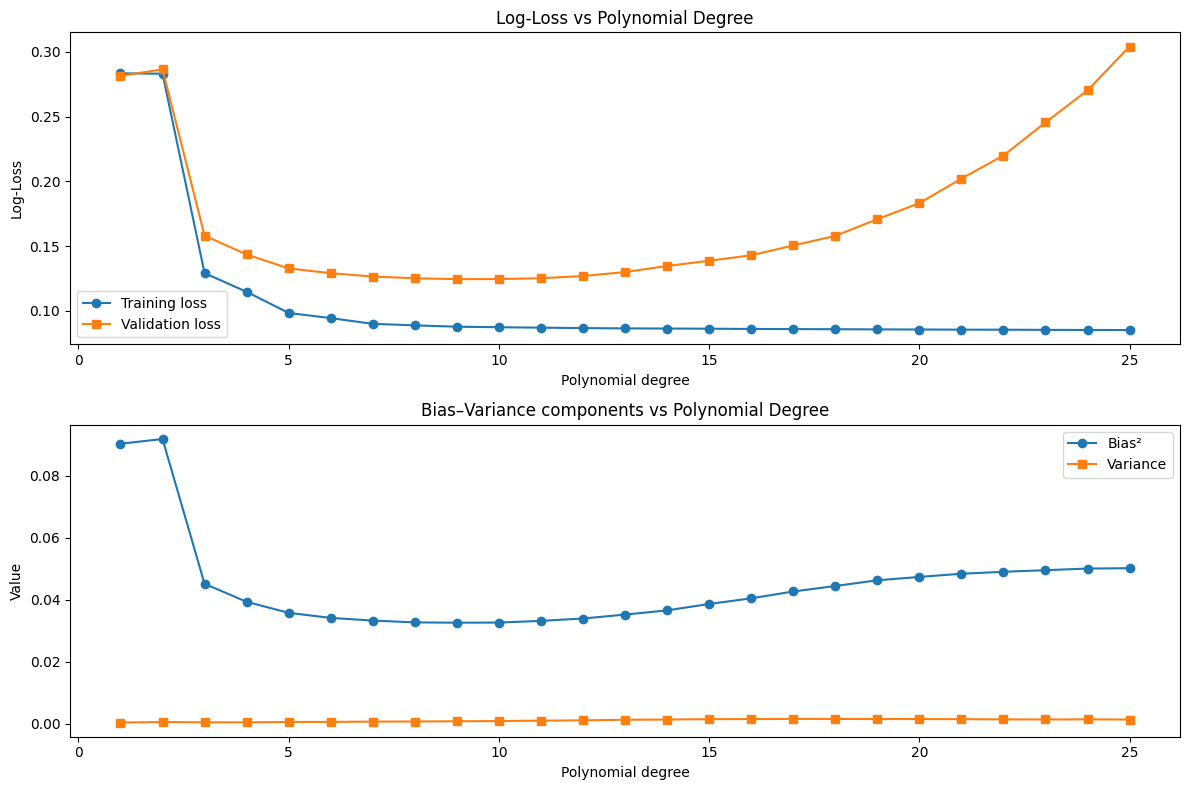

In [8]:

plt.figure(figsize=(12, 8))

# a) Train / Validation error
plt.subplot(2, 1, 1)
plt.plot(degrees, train_losses, 'o-', label='Training loss')
plt.plot(degrees, val_losses,   's-', label='Validation loss')
plt.title('Log‑Loss vs Polynomial Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Log‑Loss')
plt.legend()

# b) Bias^2 + Variance
plt.subplot(2, 1, 2)
plt.plot(degrees, bootstrap_b2, 'o-', label='Bias²')
plt.plot(degrees, bootstrap_variance, 's-', label='Variance')
plt.title('Bias–Variance components vs Polynomial Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

## Load Scientific stack

In [9]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for machine learning utilities
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, recall_score, 
    f1_score, roc_curve, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier



### Bias and Variance

+ **Bias** refers to the error due to overly simplistic assumptions in the learning algorithm.
    - High bias models tend to underfit the data.
    - Example: tryint to use linear models on highly non-linear data.

+ **Variance** refers to the model's sensitivity to fluctuations in the training data.
    - High variance models tend to overfit the training data and perform poorly on unseen data.
    - Example: Very deep decision trees memorizing noise.

The goal is to **find a balance** between bias and variance for better generalization.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Dataset: intentionally harder and with fewer samples
X, y = make_classification(
    n_samples=150,  # smaller sample size to provoke overfitting
    n_features=10,
    n_informative=5,
    n_redundant=2,
    flip_y=0.15,  # introduce label noise
    class_sep=0.5,  # less separation between classes
    random_state=0
)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0
)

# Simple model: high bias
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

#extract predictions
y_pred_lr = logreg.predict(X_test)

# Complex model: high variance
deep_tree = DecisionTreeClassifier(max_depth=None, random_state=0)
deep_tree.fit(X_train, y_train)

# Accuracy on train and test sets
def print_acc(model, name):
    acc_train = model.score(X_train, y_train)
    acc_test = model.score(X_test, y_test)
    print(f"{name}\nTrain Acc: {acc_train:.2f} | Test Acc: {acc_test:.2f}\n")

print_acc(logreg, "Logistic Regression (High Bias)")
print_acc(deep_tree, "Deep Decision Tree (High Variance)")


Logistic Regression (High Bias)
Train Acc: 0.60 | Test Acc: 0.53

Deep Decision Tree (High Variance)
Train Acc: 1.00 | Test Acc: 0.60



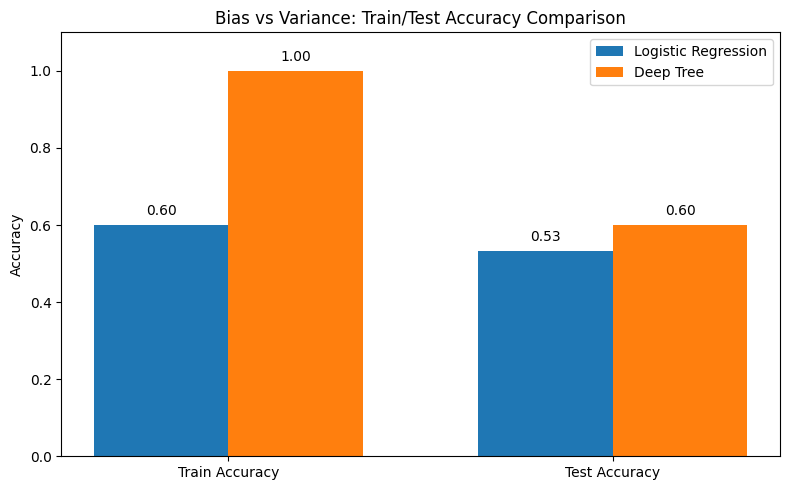

In [11]:
# Get accuracy scores
logreg_train_acc = logreg.score(X_train, y_train)
logreg_test_acc = logreg.score(X_test, y_test)

tree_train_acc = deep_tree.score(X_train, y_train)
tree_test_acc = deep_tree.score(X_test, y_test)

# Bar chart for comparison
labels = ['Train Accuracy', 'Test Accuracy']
logreg_scores = [logreg_train_acc, logreg_test_acc]
tree_scores = [tree_train_acc, tree_test_acc]

x = np.arange(len(labels))  # the label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, logreg_scores, width, label='Logistic Regression')
bars2 = ax.bar(x + width/2, tree_scores, width, label='Deep Tree')

# Labels and formatting
ax.set_ylabel('Accuracy')
ax.set_title('Bias vs Variance: Train/Test Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.1)
ax.legend()

# Annotate each bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


# The $p\text{-}value$

### What Is a $p\text{-}value$?
In hypothesis testing the $p\text{-}value$ is a probability that quantifies how extreme your observed data are under the null hypothesis ($H_0$).

+ $p\text{-}value$ = probability of observing your data (or more extreme) assuming $H_0$ is true.

### How is p-value used?

+ if $p\text{-}value \leq \alpha $ reject $H_0$
+ if $p\text{-}value > \alpha $ do not reject $H_0$

### Problems with $p\text{-}value$

+ A small $p\text{-}value$ does not mean the effect is large or practically important.
+ A large $p\text{-}value$ does not prove $H_0$ is true—just that the data did not provide enough evidence to reject it.

# Classic Misconceptions

+ $p\text{-}value$ = probability that $H_0$ is true. **Totally incorrect never do it you will have problems**
+ If $p\text{-}value>\alpha$, $H_0$ is proven - **No evidence to reject, but $H_0$ remains plausible.**
+ Statistical significance = practical significance. **Not necessarily; check effect size & confidence intervals.**
+ A $p\text{-}value < 0.05$ means the null hypothesis is false. **It means the data are unlikely under H₀, not that H₀ is false with certainty.**

# Example Are Male and Female Salaries Different?

### The Question
+ Null hypothesis ($H_0$ ): The average salary of men equals the average salary of women.
+ Alternative hypothesis ($H_1$): The average salaries differ (two‑tailed). 

In [12]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------
# 1.1  Read the CSV
# -------------------------------------------------
df = pd.read_csv('data/salaries.csv')          # <-- change file name / path

# -------------------------------------------------
# 1.2  Inspect the first rows
# -------------------------------------------------
print(df.head())
print(df.columns)            # show column names
print(df.dtypes) 

  Gender    Salary
0   Male  72241.12
1   Male  72061.66
2   Male  59686.70
3   Male  77773.71
4   Male  72279.07
Index(['Gender', 'Salary'], dtype='object')
Gender     object
Salary    float64
dtype: object


In [13]:
# 2.1  Keep only relevant columns
df = df[['Gender', 'Salary']].copy()

# 2.2  Drop rows with missing salaries or genders
df.dropna(subset=['Gender', 'Salary'], inplace=True)

In [14]:
# 2.3  Make sure gender values are consistent
df['Gender'] = df['Gender'].str.strip().str.title()   # 'male' → 'Male'

# 2.4  Verify gender distribution
print(df['Gender'].value_counts())

# 2.5  Check salary range (just to spot obvious outliers)
print(df['Salary'].describe())

Gender
Male    5
Name: count, dtype: int64
count        5.000000
mean     70808.452000
std       6670.719072
min      59686.700000
25%      72061.660000
50%      72241.120000
75%      72279.070000
max      77773.710000
Name: Salary, dtype: float64


# Box‑plots / Violin‑plots

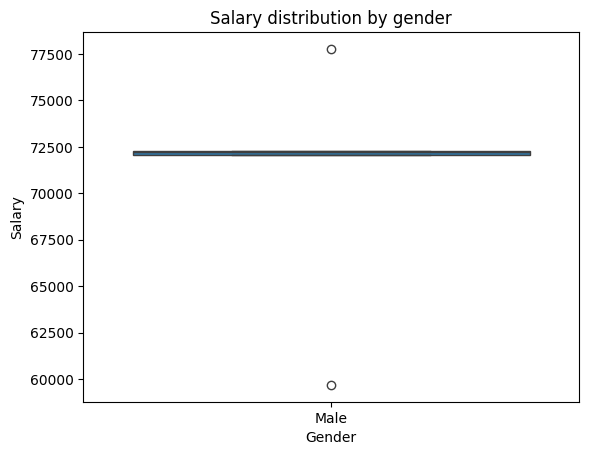

In [15]:
sns.boxplot(x='Gender', y='Salary', data=df)
plt.title('Salary distribution by gender')
plt.show()

# Normality Test (Shapiro–Wilk)

In [16]:
male  = df[df['Gender']=='Male']['Salary'].values
female = df[df['Gender']=='Female']['Salary'].values

print('Male normality p‑value:', st.shapiro(male).pvalue)
print('Female normality p‑value:', st.shapiro(female).pvalue)

Male normality p‑value: 0.11470676207461739
Female normality p‑value: nan


C:\Users\nxf33012\AppData\Local\Temp\ipykernel_2624\3397367028.py:5: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  print('Female normality p‑value:', st.shapiro(female).pvalue)


## Nope no normality, we need to use use a non‑parametric test (Mann–Whitney U)

In [17]:
u_stat, p_value_mw = st.mannwhitneyu(
    male,
    female,
    alternative='two-sided'
)

print(f"U‑statistic = {u_stat:.0f}, p‑value = {p_value_mw:.20f}")

U‑statistic = nan, p‑value = nan


C:\Users\nxf33012\AppData\Local\Temp\ipykernel_2624\4108895095.py:1: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  u_stat, p_value_mw = st.mannwhitneyu(


### We reject $H_0$ with all the caveats mentioned before

# Statistical Test Demo
Showing α (Type I) and β (Type II) Errors in Practice

+ Generates two normally‑distributed populations
+ Performs a two‑sample t‑test
+ Shows how the chosen significance level α controls the false‑positive rate
+ Estimates the β (false‑negative) rate by repeated simulation (i.e. the power of the test)



In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Statistical Test Demo – α (Type‑I) & β (Type‑II) Errors

+ Samples are coming $N(0, 1)$ vs $N(\delta, 1)$
+ **Test:** two‑sample t‑test (different means, equal variances)
+ **α = 0.05**  *(pre‑chosen significance level)*
+ **β** is estimated by Monte‑Carlo simulation:  
  + count how often we _fail_ to reject $H_0$ when it is false  
    *(power = 1 – β)*

The script plots:


+ The empirical α (false‑positive) vs β (false‑negative) for various sample sizes

<figure>
  <img src="Images/types.svg" alt="Errors">
  <figcaption>Figure 1: Errors</figcaption>
</figure>

# Helper: run a single two‑sample t‑test and return p‑value
## A t-test is a statistical test used to compare the means of two groups/classes and determine if there's a statistically significant difference between them. 

In [19]:
def two_sample_t_test(x, y):
    """Return the two‑sided p‑value from an independent t‑test."""
    t_stat, p_val = stats.ttest_ind(x, y, equal_var=True)
    return p_val

# Parameters

In [20]:
alpha = 0.05         # chosen significance level
delta = 2.0          # true mean difference (effect size)
sigma = 1.0          # common standard deviation
n_reps = 10000       # number of simulation repetitions
sample_sizes = [10, 20, 30, 50, 80, 120]  # sample size per group

# Simulate a Monte Carlo Estimation of empirical alpha (Type I error)

### alpha is the probability of rejecting a true null hypothesis $H_0$

## The classes are identical 

In [21]:
emp_alpha = []
for n in sample_sizes:
    rejects = 0
    for _ in range(n_reps):
        # Identical Classes
        group1 = np.random.normal(loc=0, scale=sigma, size=n)
        group2 = np.random.normal(loc=0, scale=sigma, size=n)
        p = two_sample_t_test(group1, group2)
        if p < alpha:
            rejects += 1
    emp_alpha.append(rejects / n_reps)

# Simulate a Monte Carlo Estimation of empirical beta (Type II error)

### power is defined as the probability of correctly rejecting a false null hypothesis $H_0$

$$Power = 1 - \beta$$

In [22]:
emp_beta = []
emp_power = []
for n in sample_sizes:
    fails = 0  # fail to reject when H0 is false
    for _ in range(n_reps):
        group1 = np.random.normal(loc=0,       scale=sigma, size=n)
        group2 = np.random.normal(loc=delta,   scale=sigma, size=n)
        p = two_sample_t_test(group1, group2)
        if p >= alpha:   # we *fail* to reject H0
            fails += 1
    beta = fails / n_reps
    power = 1 - beta
    emp_beta.append(beta)
    emp_power.append(power)

# Visualise the results

### The distributions for a single run  

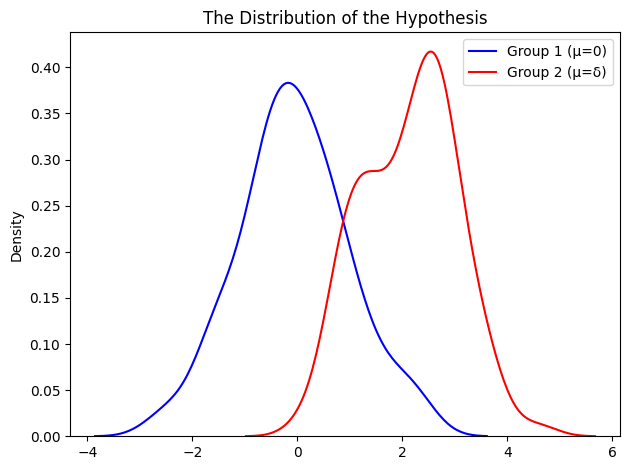

In [23]:
n_samples = 100
g1 = np.random.normal(loc=0,   scale=sigma, size=n_samples)
g2 = np.random.normal(loc=delta,scale=sigma, size=n_samples)

sns.kdeplot(g1, label="Group 1 (μ=0)", color="blue")
sns.kdeplot(g2, label="Group 2 (μ=δ)", color="red")
plt.title(f"The Distribution of the Hypothesis")
plt.legend()
plt.tight_layout()
plt.show()

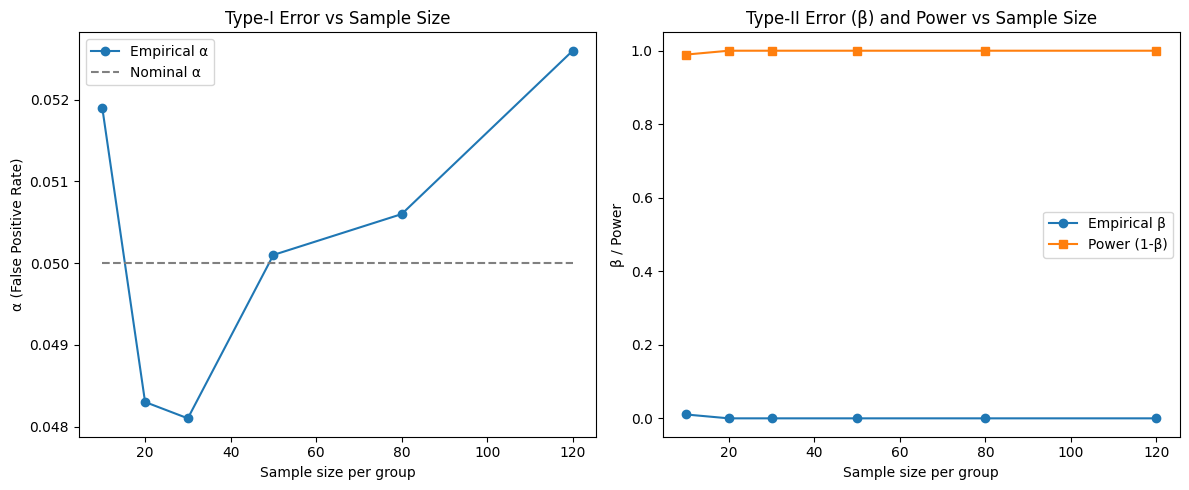

In [36]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(sample_sizes, emp_alpha, 'o-', label="Empirical α")
plt.hlines(alpha, xmin=sample_sizes[0], xmax=sample_sizes[-1], colors='gray',
           linestyles='dashed', label="Nominal α")
plt.xlabel("Sample size per group")
plt.ylabel("α (False Positive Rate)")
plt.title("Type‑I Error vs Sample Size")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sample_sizes, emp_beta, 'o-', label="Empirical β")
plt.plot(sample_sizes, emp_power, 's-', label="Power (1-β)")
plt.xlabel("Sample size per group")
plt.ylabel("β / Power")
plt.title("Type‑II Error (β) and Power vs Sample Size")
plt.legend()

plt.tight_layout()
plt.show()

Confusion matrix 
===

A **confusion matrix** is a simple and intuitive tool to summarize prediction results for classification problems.

|                 | Predicted Positive | Predicted Negative |
|-----------------|--------------------|--------------------|
| **Actual Positive** | True Positive (TP)     | False Negative (FN)    |
| **Actual Negative** | False Positive (FP)    | True Negative (TN)     |

From this, we derive the following metrics:

- **Accuracy** = (TP + TN) / Total
- **Precision** = TP / (TP + FP) : How many predicted positives are truly positive?
- **Recall (Sensitivity)** = TP / (TP + FN) : How many actual positives were detected?
- **F1 Score** = 2 × (Precision × Recall) / (Precision + Recall) : Harmonic mean of precision and recall

These metrics are especially useful when the data is **imbalanced**.

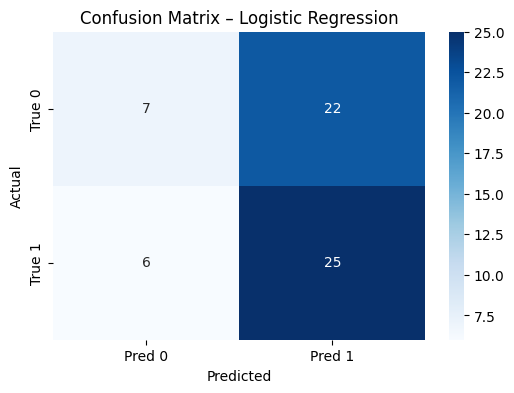

In [25]:
# Confusion matrix for Logistic Regression
cm = confusion_matrix(y_test, y_pred_lr)

# Display with seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()


In [26]:
# Print classification report
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))

# Extract individual metrics
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

print(f"Recall (Sensitivity): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.54      0.24      0.33        29
           1       0.53      0.81      0.64        31

    accuracy                           0.53        60
   macro avg       0.54      0.52      0.49        60
weighted avg       0.54      0.53      0.49        60

Recall (Sensitivity): 0.81
F1 Score: 0.64


# The Multi Class case using Micro Averages

In [27]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

# Helper to pretty‑print a dict of metrics

In [28]:

def print_metrics(name, y_true, y_pred, avg='micro'):
    print(f"\n{name} (average={avg}):")
    print(f"  Precision: {precision_score(y_true, y_pred, average=avg):.4f}")
    print(f"  Recall:    {recall_score(y_true, y_pred, average=avg):.4f}")
    print(f"  F1:        {f1_score(y_true, y_pred, average=avg):.4f}")
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nFull classification report:")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))

# Generate a toy imbalanced multi‑class data set

In [29]:
# 3 classes, 2000 samples, heavily imbalanced
X, y = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=12,
    n_redundant=5,
    n_classes=3,
    n_clusters_per_class=1,
    weights=[0.7, 0.25, 0.05],   # 70% class 0, 25% class 1, 5% class 2
    flip_y=0.01,
    random_state=42,
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Train logistic regression with class_weight='balanced'

In [30]:
clf = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


# Micro-averaged metrics

In [31]:
y_pred = clf.predict(X_test)

# Step 5: Micro-averaged metrics
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_micro = f1_score(y_test, y_pred, average='micro')

In [32]:

precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("=== Micro-Averaged Metrics ===")
print(f"Precision (micro): {precision_micro:.4f}")
print(f"Recall (micro):    {recall_micro:.4f}")
print(f"F1 Score (micro):  {f1_micro:.4f}")

=== Micro-Averaged Metrics ===
Precision (micro): 0.9167
Recall (micro):    0.9167
F1 Score (micro):  0.9167


# Macro-averaged for comparison

In [33]:
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print("\n=== Macro-Averaged Metrics (for comparison) ===")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro):    {recall_macro:.4f}")
print(f"F1 Score (macro):  {f1_macro:.4f}")


=== Macro-Averaged Metrics (for comparison) ===
Precision (macro): 0.7878
Recall (macro):    0.8919
F1 Score (macro):  0.8216


# Full classification report

In [34]:
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))


=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9797    0.9236    0.9509       419
           1     0.9195    0.9133    0.9164       150
           2     0.4643    0.8387    0.5977        31

    accuracy                         0.9167       600
   macro avg     0.7878    0.8919    0.8216       600
weighted avg     0.9380    0.9167    0.9240       600



# Precision in Computer Vision IoU

In [37]:
%pip install torch

import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 1.0/241.3 MB 7.6 MB/s eta 0:00:32
    --------------------------------------- 3.7/241.3 MB 11.1 MB/s eta 0:00:22
   - -------------------------------------- 7.6/241.3 MB 13.8 MB/s eta 0:00:17
   - -------------------------------------- 11.0/241.3 MB 15.0 MB/s eta 0:00:16
   -- ------------------------------------- 14.4/241.3 MB 14.7 MB/s eta 0:00:16
   -- ------------------------------------- 17.3/241.3 MB 14.5 MB/s eta 0:00:16
   --- ------------------------------------ 20.4/241.3 MB 14.5 MB/s eta 0:00:16
   --- ------------------------------------ 24.1/241.3 MB 14.9 MB/s eta 0:00:15
   ---- ----------------------------------- 27.5/241.3 MB 15.1 MB/s eta 0:00:15
   ----- ---------------------------------- 31.5/241.3 MB 15.5 MB/s eta 0:00:14
   ----- ---------------------------------- 35.1/241.3 MB 15.6 MB/s eta 0:00:14
   ------ --------------------------------- 36.7/241.

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


ModuleNotFoundError: No module named 'torchvision'

# IoU the bounding box

In [ ]:
def iou(boxA, boxB):
    """
    boxA, boxB: (x1, y1, x2, y2) – float tensors (or numpy arrays)
    returns: float IoU
    """
    # intersection
    inter_top_left  = torch.max(boxA[:2], boxB[:2])
    inter_bot_right = torch.min(boxA[2:], boxB[2:])
    inter_wh = (inter_bot_right - inter_top_left).clamp(min=0) # Basically you can define a min or max
    inter_area = inter_wh[0] * inter_wh[1]

    # union
    areaA = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
    union = areaA + areaB - inter_area

    return inter_area / union

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet‑50 + FPN trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device).eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160M/160M [00:06<00:00, 26.2MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
device

device(type='cpu')

# Load a single Image

In [ ]:
img_path = "data/coco_images/istockphoto-962596556-612x612_jpg.rf.673a1eabc051e188df003634594b862b.jpg"

In [ ]:
ann_path = "data/coco_images/_annotations.coco.json"

In [ ]:
img = torchvision.io.read_image(img_path).to(device)

In [ ]:
tran = T.Compose([
              T.ToTensor()
            ])
img = tran(img.numpy())

In [ ]:
img.shape

torch.Size([640, 3, 640])

In [ ]:
img_np = img.permute(2, 0, 1).cpu().numpy()
img_model = img.permute(1, 2, 0).cpu()

In [ ]:
img_np.shape

(640, 640, 3)

# Load Annotations

In [ ]:
from pycocotools.coco import COCO
import os
coco = COCO(ann_path)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
img_id = 12
ann_ids = coco.getAnnIds(imgIds=[img_id], iscrowd=False)
anns = coco.loadAnns(ann_ids)[0]

In [ ]:
anns

{'id': 20,
 'image_id': 12,
 'category_id': 1,
 'bbox': [128, 63, 264.5, 499],
 'area': 131985.5,
 'segmentation': [],
 'iscrowd': 0}

In [ ]:
gt_bbox = torch.tensor(anns["bbox"], dtype=torch.float32).to(device)   # (x, y, w, h)
gt_bbox[2:] += gt_bbox[:2]                                            # → (x1, y1, x2, y2)

In [ ]:
gt_bbox

tensor([128.0000,  63.0000, 392.5000, 562.0000])

# Convert back to numpy for matplotlib

(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

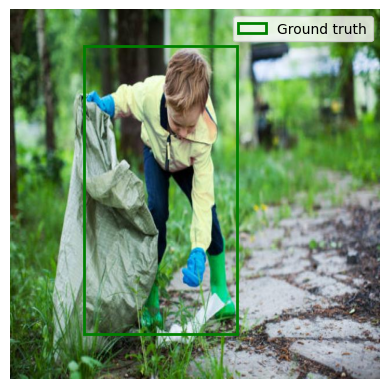

In [ ]:
plt.imshow(img_np)
ax = plt.gca()

# Ground‑truth (green)
gt_rect = plt.Rectangle((gt_bbox[0], gt_bbox[1]),
                       gt_bbox[2]-gt_bbox[0],
                       gt_bbox[3]-gt_bbox[1],
                       linewidth=2, edgecolor='g', facecolor='none',
                       label='Ground truth')
ax.add_patch(gt_rect)
plt.legend()
plt.axis('off')

In [ ]:
with torch.no_grad():
    pred = model([img_model])[0]                # one dict per image

# Take the *most confident* prediction
score, idx = torch.max(pred["scores"], dim=0)
pred_box = pred["boxes"][idx]            # (x1, y1, x2, y2)
pred_label = pred["labels"][idx]         # class id (1‑based in COCO)
pred_score = pred["scores"][idx]

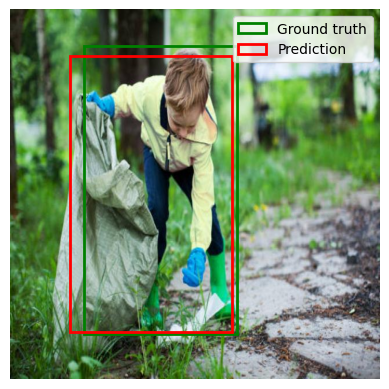

In [ ]:
plt.imshow(img_np)
ax = plt.gca()

# Ground‑truth (green)
gt_rect = plt.Rectangle((gt_bbox[0], gt_bbox[1]),
                       gt_bbox[2]-gt_bbox[0],
                       gt_bbox[3]-gt_bbox[1],
                       linewidth=2, edgecolor='g', facecolor='none',
                       label='Ground truth')
ax.add_patch(gt_rect)

# Prediction (red)
pred_rect = plt.Rectangle((pred_box[0], pred_box[1]),
                          pred_box[2]-pred_box[0],
                          pred_box[3]-pred_box[1],
                          linewidth=2, edgecolor='r', facecolor='none',
                          label='Prediction')
ax.add_patch(pred_rect)

plt.legend()
plt.axis('off')
plt.show()

## ROC Curve and AUC (Area Under the Curve)

The **ROC curve (Receiver Operating Characteristic)** shows the tradeoff between:

- **True Positive Rate (Recall)** on the Y-axis
- **False Positive Rate** on the X-axis

A perfect classifier would reach the top-left corner of the ROC plot.

- The **AUC** (Area Under the Curve) is a single number summary of the ROC curve.
  - AUC = 1.0 : Perfect classification
  - AUC = 0.5 : No better than random guessing

ROC and AUC are especially useful for **binary classifiers** and when evaluating **probabilistic models**.


In [ ]:
# Get predicted probabilities
y_proba_lr = logreg.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
auc_score = roc_auc_score(y_test, y_proba_lr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
i = iou(pred_box, gt_bbox).item()
print(f"Pred box:   {pred_box.tolist()}")
print(f"GT  box:    {gt_bbox.tolist()}")
print(f"IoU: {i:.3f}")

# Simple decision rule (e.g. IoU ≥ 0.5 is a true positive)
is_tp = i >= 0.5
print("TP?" , is_tp)

Pred box:   [103.3697280883789, 79.3836441040039, 383.4300231933594, 558.2218627929688]
GT  box:    [128.0, 63.0, 392.5, 562.0]
IoU: 0.851
TP? True


# Precision-Recall and ROC Curve Example 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score, recall_score,
                             confusion_matrix, classification_report,
                             roc_curve, auc)

# Helper to print a formatted confusion matrix
def print_cm(cm):
    print("Confusion matrix:")
    print(pd.DataFrame(cm,
                       index=["Actual 0", "Actual 1"],
                       columns=["Pred 0", "Pred 1"]))

# Load Cancer Data

In [ ]:
X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]], shape=(569, 30))

## Train Classifier

In [ ]:
log_reg = LogisticRegression(max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


## Probabilities for the positive class (malignant)

In [ ]:
probs_pos = log_reg.predict_proba(X_test)[:, 1]

##  Default 0.5 Threshold

In [ ]:
threshold = 0.5
y_pred_default = (probs_pos >= threshold).astype(int)

## Report

In [ ]:
print("=== Default Threshold = 0.5 ===")
print_cm(confusion_matrix(y_test, y_pred_default))
print(f"Precision: {precision_score(y_test, y_pred_default):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_default):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_default, digits=4))

=== Default Threshold = 0.5 ===
Confusion matrix:
          Pred 0  Pred 1
Actual 0      48       5
Actual 1       1      89
Precision: 0.9468
Recall   : 0.9889

Classification Report:
              precision    recall  f1-score   support

           0     0.9796    0.9057    0.9412        53
           1     0.9468    0.9889    0.9674        90

    accuracy                         0.9580       143
   macro avg     0.9632    0.9473    0.9543       143
weighted avg     0.9590    0.9580    0.9577       143



## Compute metrics for all thresholds (including 0.01 to 0.99 step 0.01)

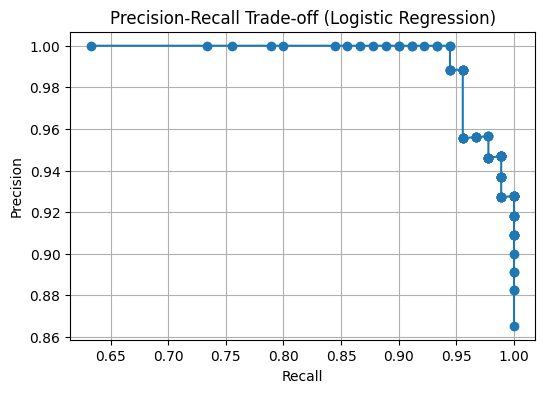

In [ ]:
ts = np.linspace(0.01, 0.99, 99)
precisions = []
recalls = []

for t in ts:
    y_pred_t = (probs_pos >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_t))
    recalls.append(recall_score(y_test, y_pred_t))

plt.figure(figsize=(6,4))
plt.plot(recalls, precisions, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision‑Recall Trade‑off (Logistic Regression)')
plt.grid(True)
plt.show()

## ROC Curve

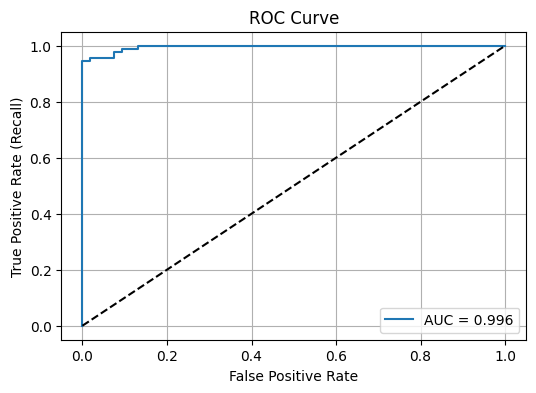

In [ ]:
fpr, tpr, _ = roc_curve(y_test, probs_pos)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Cross-Validation for Precision Metrics

**Cross-validation** is a technique to evaluate the stability and generalizability of a model.

- The dataset is split into multiple **folds**
- The model is trained and tested on different splits
- Metrics  are averaged over all folds

Benefits:
- Reduces bias from a single train/test split
- Provides more **robust and reliable** estimates
- Helps identify overfitting

Common approach: **Stratified K-Fold**, which preserves class proportions across folds.


In [ ]:
# Use stratified k-fold to maintain class balance in folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validated F1 score
cv_f1_scores = cross_val_score(logreg, X, y, scoring='f1', cv=skf)

print("Cross-validated F1 scores:", cv_f1_scores)
print("Mean F1 score:", np.mean(cv_f1_scores))


## Other Useful Evaluation Tools

Besides standard metrics, here are additional tools to improve model evaluation:

- **Balanced Accuracy**: Especially important when classes are imbalanced.
  
  Balanced Accuracy = 1/2* TP/(TP+FN) + TN/(TN+FP)
  

- **Precision-Recall Curve**: More informative than ROC when dealing with imbalanced datasets.

- **Confusion Matrix Normalized**: Helps interpret proportions, not just counts.

Always tailor your evaluation strategy to the **problem context**: imbalanced data, false negative cost, etc.


In [ ]:
# Balanced Accuracy (especially useful for imbalanced datasets)
from sklearn.metrics import balanced_accuracy_score

# Simulate an imbalanced dataset (we control the imbalance with weights)
X_imb, y_imb = make_classification(n_samples=500, weights=[0.85, 0.15], random_state=42)
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_imb, y_imb, test_size=0.3, stratify=y_imb, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_i, y_train_i)
y_pred_i = clf.predict(X_test_i)

balanced_acc = balanced_accuracy_score(y_test_i, y_pred_i)
print(f"Balanced Accuracy (Imbalanced Data): {balanced_acc:.2f}")
